<a href="https://colab.research.google.com/github/joydata2023/github_colab_project/blob/main/Project_2_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conversion Analysis on Web Design using Python**

## 1. Introduction

For this project, I will be analyzing the results of a/b test run by an e-commerce website. The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



## 2.Import data and data cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
df = pd.read_excel('Copy of sample ab_data.xlsx')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,1
3,853541,28:03.1,treatment,new_page,1
4,864975,52:26.2,control,old_page,1


Get an overview of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### 2.1 EDA: analyze relationship betweetn 'time' and 'converted'

<Axes: >

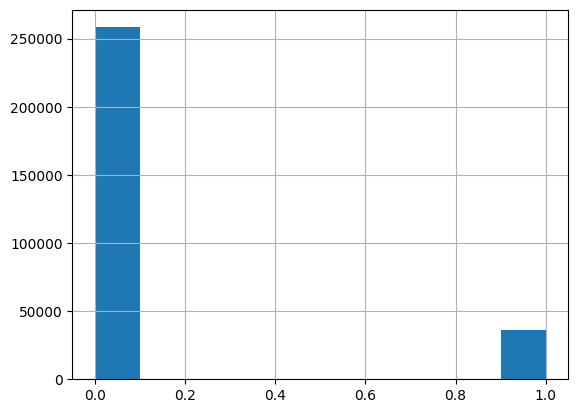

In [ ]:
df['converted'].hist()

In [ ]:
# extract the first part of 'timestamp' and group by it
df['time_group'] = df['timestamp'].str.split(':').str[0]
df.head()

,user_id,timestamp,group,landing_page,converted,time_group
0,851104,11:48.6,control,old_page,0,11
1,804228,01:45.2,control,old_page,0,01
2,661590,55:06.2,treatment,new_page,1,55
3,853541,28:03.1,treatment,new_page,1,28
4,864975,52:26.2,control,old_page,1,52


In [ ]:
df1 = df.groupby(['time_group','group']).agg({'converted':'mean'})
df1.head()

converted
time_group group               
00         control     0.119693
           treatment   0.123333
01         control     0.128381
           treatment   0.116776
02         control     0.118791

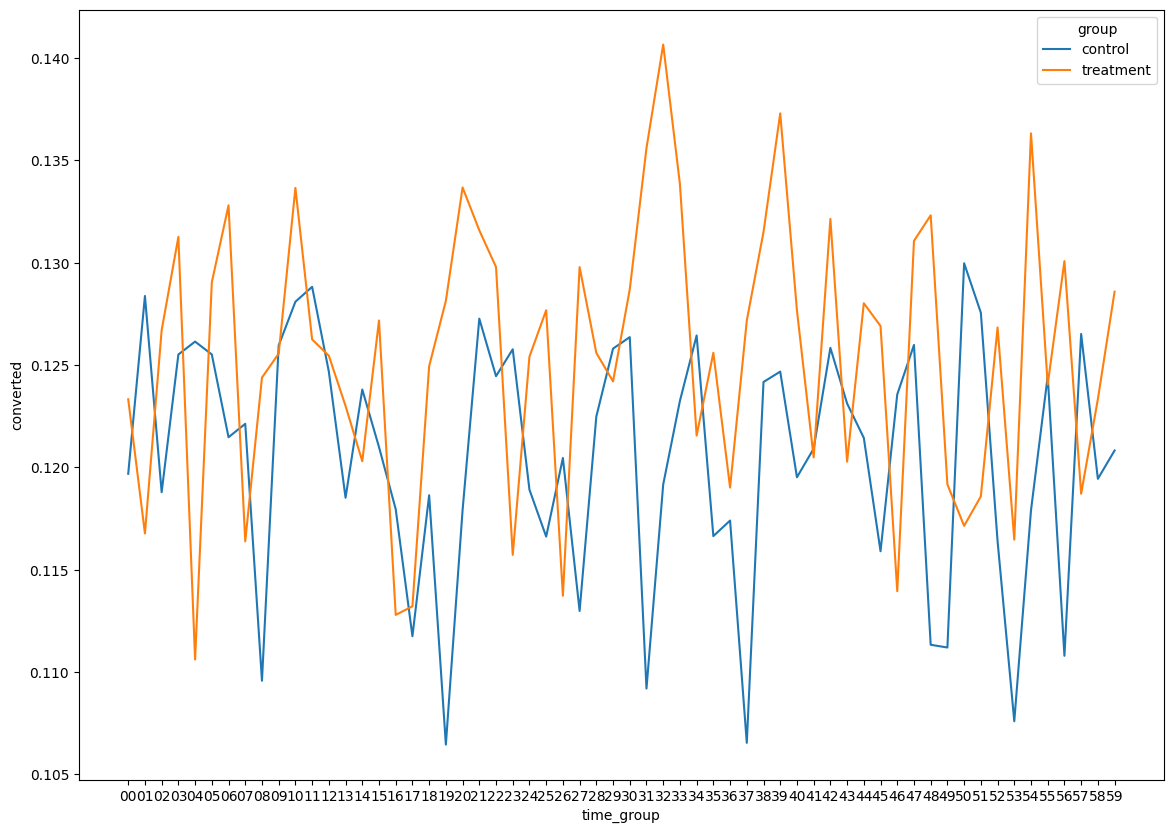

In [ ]:
# visualize the relationship between 'time_group' and 'converted'
plt.figure(figsize=(14,10))
sns.lineplot(data=df1, x='time_group',y='converted',hue='group')
plt.xticks (rotation= 90)
#From the below figure, we can find that for most time group, the treatment group has higher conversion rate than the control group.

Check if 'group' align with 'landing_page' and the number of misaligned values

In [ ]:
((df['group'] == 'control') & (df['landing_page'] == 'new_page')).sum()
# In control group, there are 1928 user_id landing in new page.

1928

In [ ]:
((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')).sum()
# In treatment group, there are 1965 user_id landing in old page.

1965

In [ ]:
df['misaligned']=((df['group'] == 'control') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))
df = df[-df['misaligned']]
df.head()

,user_id,timestamp,group,landing_page,converted,misaligned
0,851104,11:48.6,control,old_page,0,False
1,804228,01:45.2,control,old_page,0,False
2,661590,55:06.2,treatment,new_page,1,False
3,853541,28:03.1,treatment,new_page,1,False
4,864975,52:26.2,control,old_page,1,False


In [ ]:
(df['misaligned'] == True).sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   misaligned    290585 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


Check unique users

In [ ]:
df.user_id.nunique()

290584

In [ ]:
df['user_id'].value_counts().sort_values(ascending=False).head()

user_id
773192    2
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

### 2.2 make assumption:

let's assume the lastest result is the most accurate

In [ ]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,37:58.8,treatment,new_page,1,False
2893,773192,55:59.6,treatment,new_page,0,False


In [ ]:
df.drop(1899, axis = 0, inplace = True)

In [ ]:
df['user_id'].value_counts().sort_values(ascending=False).head()

user_id
851104    1
834487    1
936923    1
679687    1
719014    1
Name: count, dtype: int64

In [ ]:
# Count the number of users in each group

df[['user_id','group']].groupby('group').count()

,user_id
group,
control,145274
treatment,145310


### 2.3 Calculate conversion rate in each group

In [ ]:
#df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean','converted':'sum'})
df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean'}) #? 为什么用converted：sum.因为不用也没有影响

,user_id,converted
group,,
control,145274,0.120386
treatment,145310,0.125353


## 3.Analyze results

Let's assume that the new page does not have higher converted rate than the old page at 5% Type I error. so the hypothsis would be:


**null:** $p_{new}$ - $p_{old}$ <=0

**alternative:** **$p_{new}$** - **$p_{old}$** > 0

In [ ]:
# calculate the convertion rate by group and create a table

convert_old = df[df['group']=='control'].converted.sum()
convert_new = df[df['group']=='treatment'].converted.sum()
n_old = len(df[df['group']=='control'].converted)
n_new = len(df[df['group']=='treatment'].converted)

print(convert_old, convert_new, n_old, n_new)

17733 18466 147202 147276


In [ ]:
conversion_dic = {'Views':{'Control':n_old, 'Test':n_new},'Converts': {'Control': convert_old, 'Test' : convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %'] = conversion_table['Converts']/conversion_table['Views']
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')


conversion_table

,Views,Converts,Conversion %
Control,147202,17733,12.0%
Test,147276,18466,12.5%


### 3.1 Z-test in our way

In [ ]:
# creat a function to run Z-test
def z_test(p1,p0,n1,n0):
  delta = p1 - p0
  p = (p1*n1 + p0*n0)/(n1+n0)
  return delta / np.sqrt(p*(1-p)*(1/n1+1/n0))  # ? 不明白为什么p*（1-p）= variance

In [ ]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [ ]:
z_value = z_test(p1,p0,n1,n0)
z_value

4.062695459865415

In [ ]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

p_value

2.4254649465982325e-05

**p_value is less than 5%, so we can reject the null hypothsis : $p_
{new}$ <= $p_{old}$, and accept the alternative hypothsis: $p_{new}$ > $p_{old}$. The new page has higher conversion rate than the old page.**

###3.2 Z-test in Statsmodels


In [ ]:
import statsmodels.api as sm

In [ ]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

z_score, p_value

(4.062695459865415, 2.4254649465946946e-05)

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

# bonus - > eda - line plot 2 color control vs treatment